In [1]:
import os 
os.environ['http_proxy'] = 'http://proxy:80'
os.environ['https_proxy'] = 'http://proxy:80'

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras import ops

import numpy as np
import matplotlib.pyplot as plt
import random

2024-08-23 12:48:09.132847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 12:48:09.492315: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 12:48:09.679943: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-23 12:48:10.520988: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-23 12:48:15.655860: W tensorflow/compiler/tf2

In [3]:
BUFFER_SIZE = 1024
BATCH_SIZE = 256
INPUT_SHAPE = (32, 32, 3)
AUTO = tf.data.AUTOTUNE

**Loading the dataset**

In [4]:
(x_train, y_train), (x_valid, y_valid) = keras.datasets.cifar100.load_data()
print(f"Training samples: {len(x_train)}")
print(f"Testing samples: {len(x_valid)}")

train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

valid_ds = tf.data.Dataset.from_tensor_slices(x_valid)
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(AUTO)

Training samples: 50000
Testing samples: 10000


2024-08-23 12:48:28.766319: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10525 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1
2024-08-23 12:48:28.767109: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10525 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1
2024-08-23 12:48:28.767728: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 10525 MB memory:  -> device: 2, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1
2024-08-23 12:48:28.768304: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 10525 MB memory:  -> device: 3, name: NVIDIA GeForce

In [5]:
#The original DMAE Paper mentions that augmentation does not provide any significant performance improvement
#But we'll still be adding it since that makes the model more robust

In [6]:
IMAGE_SIZE = 72
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75

In [7]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            L.Rescaling(1 / 255.0),
            L.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            L.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            L.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [L.Rescaling(1 / 255.0), L.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model

**Divide image into patches**

In [8]:
class Patches(L.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.resize = L.Reshape((-1, patch_size * patch_size * 3))

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.suptitle('Original Image')
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        plt.suptitle('Patches')
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        return idx

    def reconstruct_from_patch(self, patch):
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

Index selected: 151.


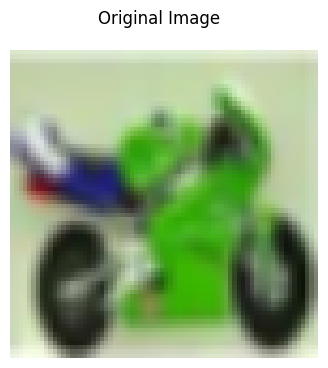

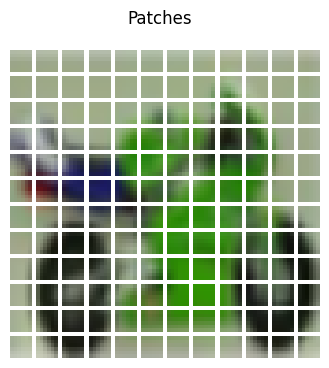

In [9]:
image_batch = next(iter(train_ds))

augmentation_model = get_train_augmentation_model()
augmented_images = augmentation_model(image_batch)

patch_layer = Patches()
patches = patch_layer(images=augmented_images)
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)

In [10]:
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 64
DEC_PROJECTION_DIM = 48
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

In [11]:
EPOCHS = 100
DOWNSTREAM_EPOCHS = 10

**Patch Encoder**

In [12]:
class PatchEncoder(L.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape
        self.projection = L.Dense(units=self.projection_dim)
        self.position_embedding = L.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )
        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,
                masked_embeddings,
                unmasked_positions,
                mask_indices,
                unmask_indices,
            )

    def get_random_indices(self, batch_size):
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]
        new_patch = np.zeros_like(patch)
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

**Teacher Network**

In [13]:
class PatchEncoder_ViT(L.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__()
        self.num_patches = num_patches
        self.projection = L.Dense(units=projection_dim)
        self.position_embedding = L.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [24]:
teacher_config = {
    'projection_dim': 128,
    'num_heads' : 4,
    'transformer_layers' : 8,
    'mlp_head_units': [2048, 1024]
}


teacher_config['transformer_units'] = [
    teacher_config['projection_dim'] * 2,
    teacher_config['projection_dim']
]


In [25]:
data_augmentation = keras.Sequential(
    [
        L.Normalization(),
        L.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        L.RandomFlip("horizontal"),
        L.RandomRotation(factor=0.02),
        L.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [26]:
def dense_projection(x, dropout_rate, hidden_units, name = None):
    for units in hidden_units:
        if name:
            #print(name + '_' + str(units))
            x = L.Dense(units, activation=tf.nn.gelu, name = name + '_' + str(units))(x)
        else:
            x = L.Dense(units, activation=tf.nn.gelu)(x)
        x = L.Dropout(dropout_rate)(x)
    return x

In [27]:
from os import name
def create_vit_classifier():
    inputs = keras.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(PATCH_SIZE)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(NUM_PATCHES, teacher_config['projection_dim'], downstream=True)(patches)

    # Create multiple layers of the Transformer block.
    for i in range(teacher_config['transformer_layers']):
        # Layer normalization 1.
        x1 = L.LayerNormalization(epsilon=1e-6, name = f"vit_lnorm_{i}__1")(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = L.MultiHeadAttention(
            num_heads=teacher_config['num_heads'], key_dim=teacher_config['projection_dim'], dropout=0.1,
            name=f"vit_attention_{i}"
        )(x1, x1)
        # Skip connection 1.
        x2 = L.Add(name = f"vit_add_{i}")([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = L.LayerNormalization(epsilon=1e-6, name = f"vit_lnorm_{i}__2")(x2)
        # MLP.
        x3 = dense_projection(x3, hidden_units=teacher_config['transformer_units'], dropout_rate=0.1, name = f"vit_dense_{i}")
        # Skip connection 2.
        encoded_patches = L.Add(name = f"vit_add_{i}_2")([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = L.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = L.Flatten()(representation)
    representation = L.Dropout(0.5)(representation)
    # Add MLP.
    features = dense_projection(representation, hidden_units=teacher_config['mlp_head_units'], dropout_rate=0.5)
    # Classify outputs.
    num_classes = 100
    logits = L.Dense(100)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    fe_model = keras.Model(inputs=inputs, outputs=model.get_layer("vit_dense_5_128").output, name="vit_interim")
    return model, fe_model

In [28]:
vit_classifier, vit_interim = create_vit_classifier()

In [29]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=0.001, weight_decay=0.0001
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/chkpt/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=1,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_valid, y_valid)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


#vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.0281 - loss: 5.0251 - top-5-accuracy: 0.1112

PermissionError: [Errno 13] Permission denied: '/chkpt'

In [32]:
vit_classifier.save_weights('./vit_128_v1.weights.h5')

In [47]:
for layer_ in vit_classifier.layers:
    layer_.trainable=False

**MAE Layers**

In [48]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS, _teacher_config = teacher_config):
    inputs = L.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for i in range(num_layers):
        x1 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
        attention_output = L.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1,
            name=f"mae_attention_{i}"
        )(x1, x1)
        x2 = L.Add()([attention_output, x])
        x3 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)
        x3 = dense_projection(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1, name = f"mae_dense_{i}")
        x = L.Add()([x3, x2])

    outputs = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    main_model = keras.Model(inputs, outputs, name="mae_encoder")

    #project intermediate output to teacher dimensions
    attention_output = main_model.get_layer("mae_attention_4").output
    out_project = dense_projection(outputs, hidden_units=teacher_config['transformer_units'], dropout_rate=0.01, name = f"mae_dense_project")

    intermediate_layer_model = keras.Model(inputs=main_model.input, outputs=out_project, name="mae_encoder_interim")
    return main_model, intermediate_layer_model

In [49]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = L.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = L.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        x1 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
        attention_output = L.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        x2 = L.Add()([attention_output, x])
        x3 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)
        x3 = dense_projection(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)
        x = L.Add()([x3, x2])

    x = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = L.Flatten()(x)
    pre_final = L.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
    outputs = L.Reshape((image_size, image_size, 3))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")

In [50]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        encoder_interim,
        teacher_model=vit_interim,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder
        self.encoder_interim = encoder_interim
        self.teacher_model = teacher_model

    def calculate_loss(self, images, test=False):
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        patches = self.patch_layer(augmented_images)
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        encoder_outputs = self.encoder(unmasked_embeddings)
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        #intermediate output
        #self.patch_layer.downstream = True
        #fe_patches = self.patch_layer(augmented_images)
        #fe_patch_embeddings = self.patch_encoder(fe_patches)

        #print('patch', patches , fe_patches)
        #print('patch_embeddings', fe_patch_embeddings)


        #print(patch_layer.downstream)

        self.patch_encoder.downstream = True
        intermediate_embeddings = self.patch_encoder(patches)
        intermediate_output = self.encoder_interim(intermediate_embeddings)

        self.patch_encoder.downstream = False

        #intermediate_output = tf.concat([intermediate_output, masked_embeddings], axis=1)

        #intermediate teacher output
        teacher_output = self.teacher_model(images)

        #distillation loss
        
        loss_distill = self.compiled_loss(intermediate_output, teacher_output)

        #self.patch_layer.downstream = False

        total_loss = self.compiled_loss(loss_patch, loss_output) + loss_distill

        return total_loss, loss_patch, loss_output, loss_distill

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output, loss_distill = self.calculate_loss(images)

        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output, loss_distill = self.calculate_loss(images, test=True)
        self.compiled_metrics.update_state(loss_patch, loss_output, loss_distill)
        return {m.name: m.result() for m in self.metrics}

**Monitoring Callbacks**

In [51]:
test_images = next(iter(valid_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Intermediate layer output
            #self.patch_encoder.downstream = True
            #intermediate_layer = self.model.encoder_interim(test_unmasked_embeddings)
            #intermediate_layer = intermediate_layer #+ test_unmasked_positions

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image)
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Resonstructed: {epoch:03d}")


            plt.show()
            plt.close()

In [52]:
train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder, enc_interim = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
    encoder_interim=enc_interim
)


mae_model.compile(
    optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)

In [53]:
#vit_interim.summary()

In [54]:
#mae_model.encoder_interim.summary()

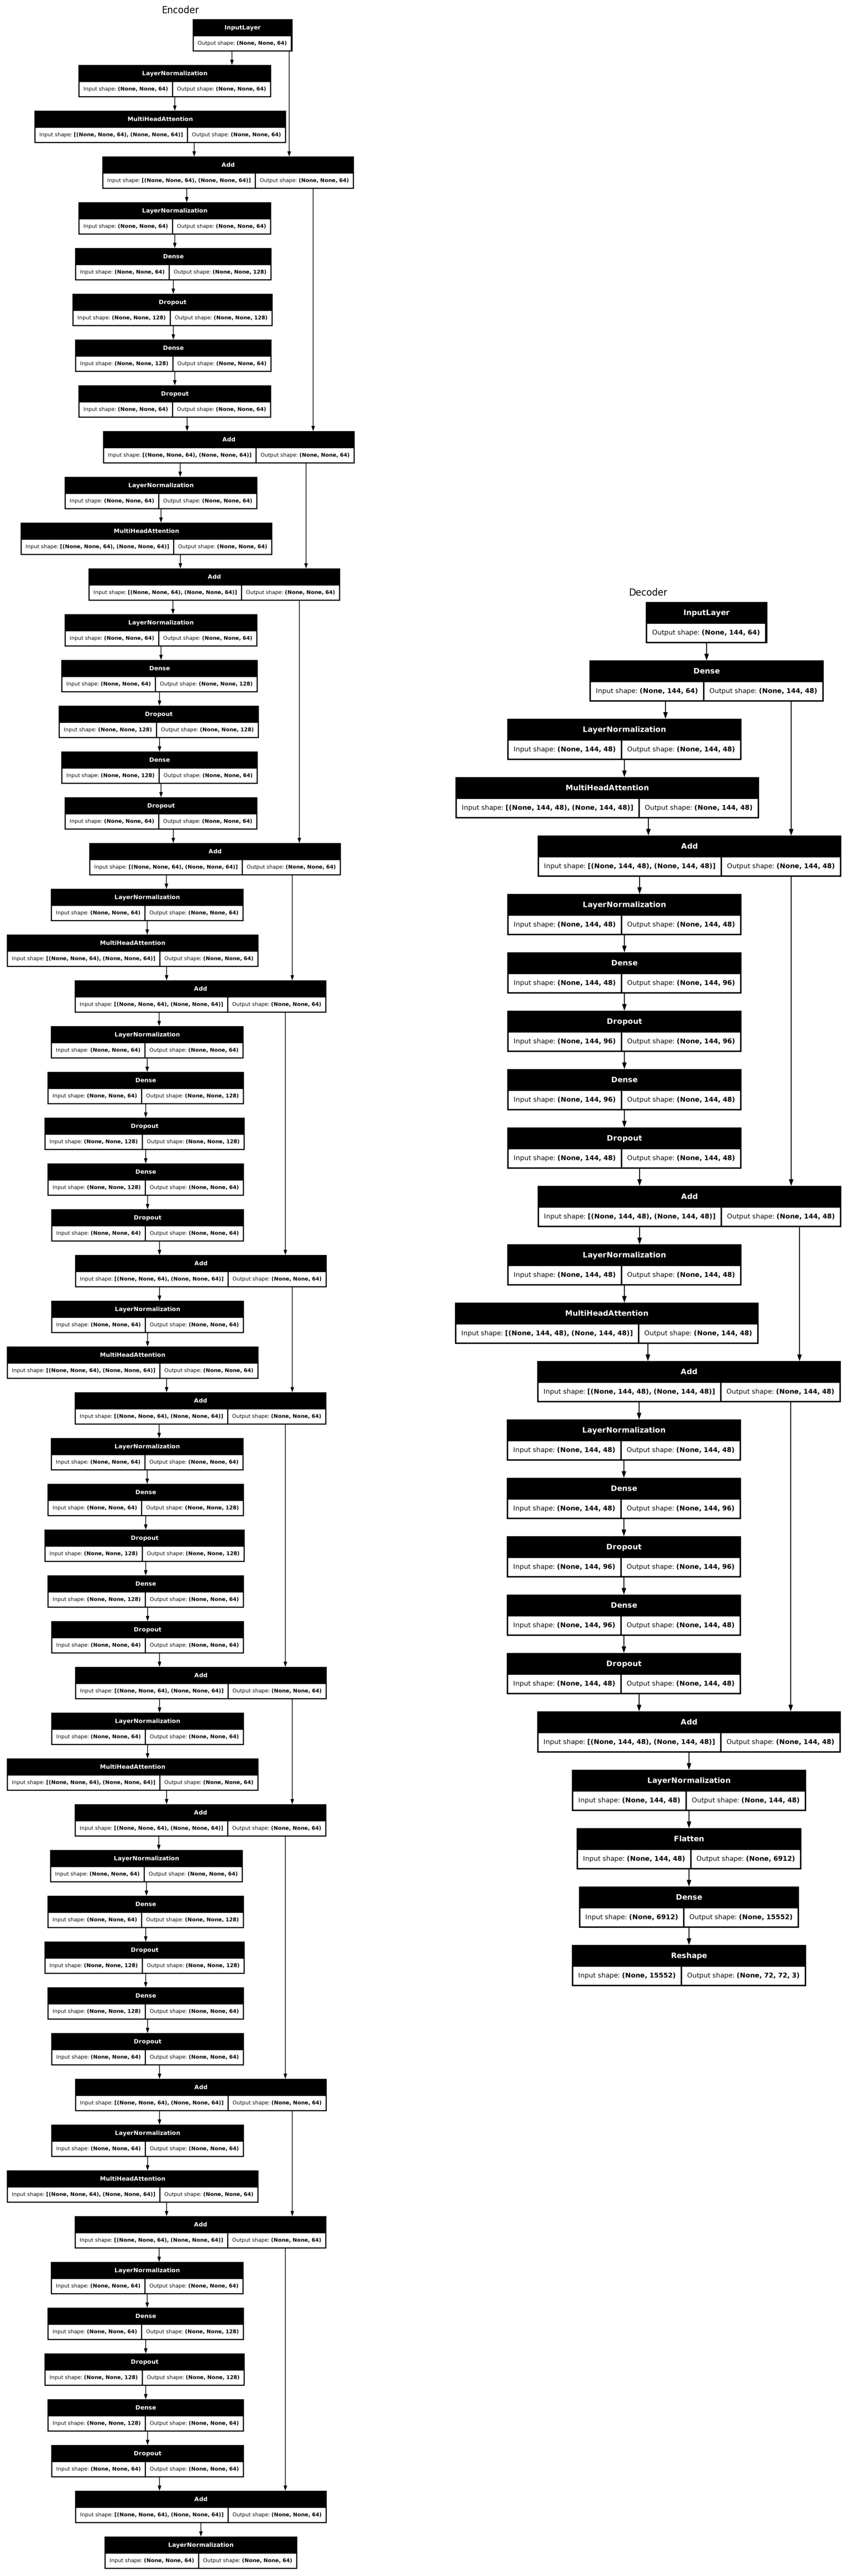

In [55]:
keras.utils.plot_model(encoder, show_shapes=True, to_file="encoder.png")
keras.utils.plot_model(decoder, show_shapes=True, to_file="decoder.png")
fig, ax = plt.subplots(1, 2, figsize=(20, 60))
ax[0].imshow(plt.imread('encoder.png'))
ax[0].set_title('Encoder', fontsize=12)
ax[0].axis("off")
ax[1].imshow(plt.imread('decoder.png'))
ax[1].set_title('Decoder', fontsize=12)
ax[1].axis("off");

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:603: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight)`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:578: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - mae: 0.2140 - loss: 0.4753
Idx chosen: 157


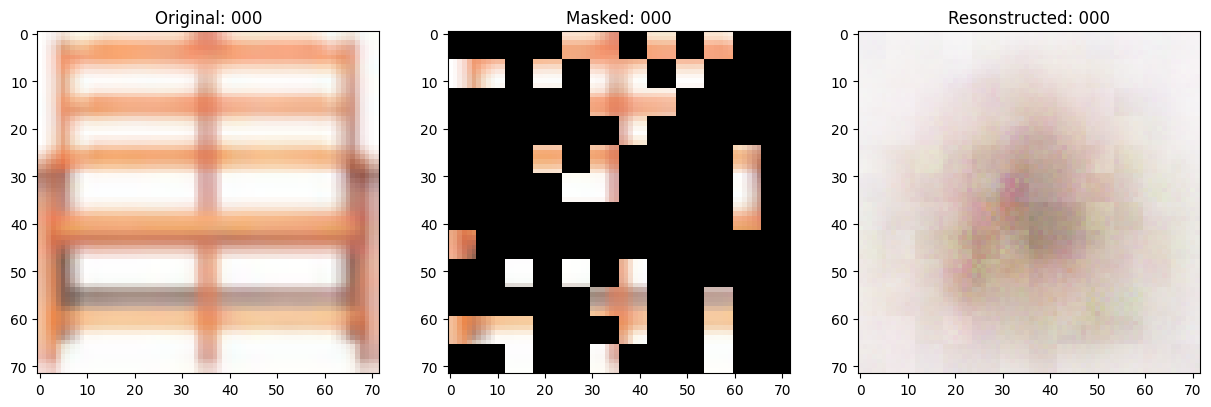

196/196 ━━━━━━━━━━━━━━━━━━━━ 180s 730ms/step - mae: 0.2138 - loss: 0.4754 - val_loss: 0.5921 - val_mae: 0.1944 - learning_rate: 0.0010
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 700ms/step - mae: 0.1700 - loss: 0.4800 - val_loss: 0.4995 - val_mae: 0.1659 - learning_rate: 0.0010
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 701ms/step - mae: 0.1655 - loss: 0.4786 - val_loss: 0.4380 - val_mae: 0.1614 - learning_rate: 0.0010
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 697ms/step - mae: 0.1590 - loss: 0.4770 - val_loss: 0.4876 - val_mae: 0.1595 - learning_rate: 0.0010
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 699ms/step - mae: 0.1547 - loss: 0.4779 - val_loss: 0.5036 - val_mae: 0.1534 - learning_rate: 0.0010
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - mae: 0.1511 - loss: 0.4781
Idx chosen: 90


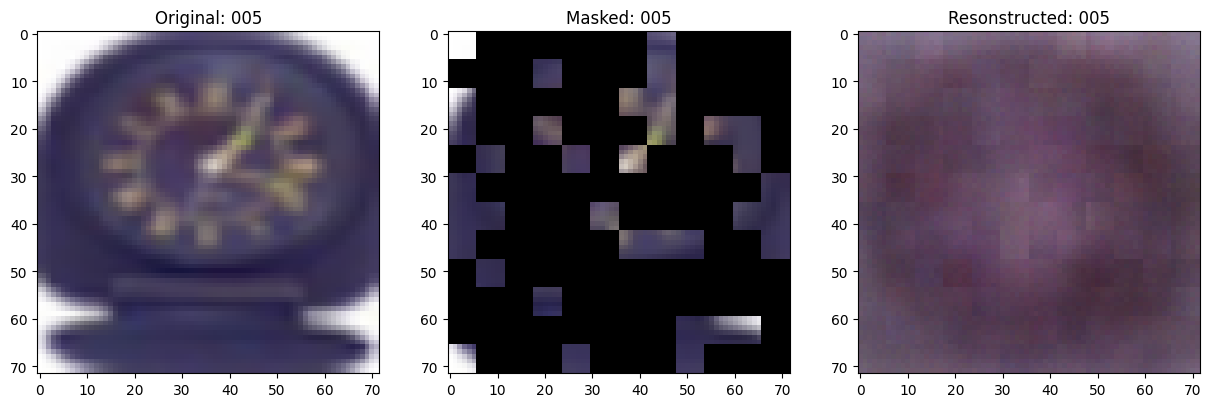

196/196 ━━━━━━━━━━━━━━━━━━━━ 138s 706ms/step - mae: 0.1511 - loss: 0.4781 - val_loss: 0.4360 - val_mae: 0.1498 - learning_rate: 0.0010
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 699ms/step - mae: 0.1444 - loss: 0.4774 - val_loss: 0.4562 - val_mae: 0.1408 - learning_rate: 0.0010
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 700ms/step - mae: 0.1399 - loss: 0.4781 - val_loss: 0.4882 - val_mae: 0.1386 - learning_rate: 0.0010
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 698ms/step - mae: 0.1389 - loss: 0.4781 - val_loss: 0.4817 - val_mae: 0.1343 - learning_rate: 0.0010
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 699ms/step - mae: 0.1357 - loss: 0.4783 - val_loss: 0.4592 - val_mae: 0.1321 - learning_rate: 0.0010
Epoch 11/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - mae: 0.1351 - loss: 0.4773
Idx chosen: 106


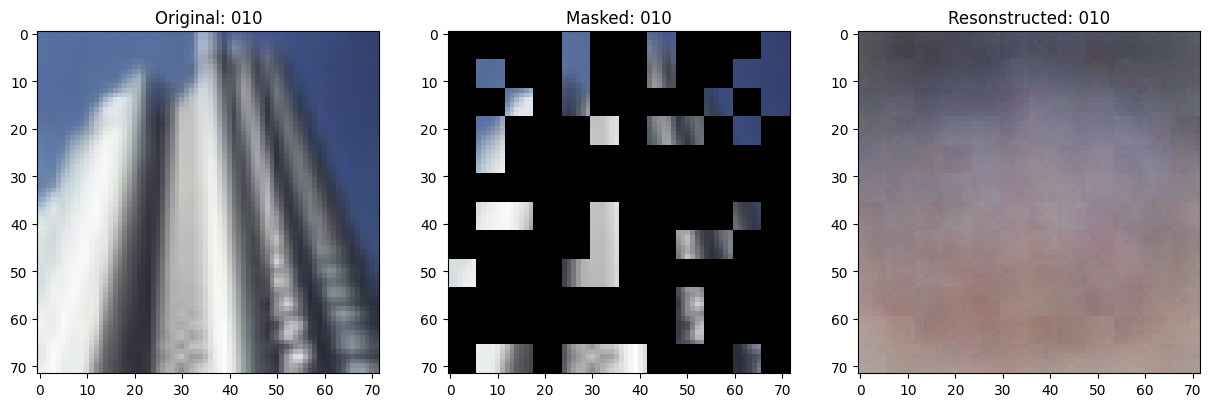


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
196/196 ━━━━━━━━━━━━━━━━━━━━ 138s 703ms/step - mae: 0.1351 - loss: 0.4773 - val_loss: 0.4855 - val_mae: 0.1333 - learning_rate: 0.0010
Epoch 12/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 698ms/step - mae: 0.1264 - loss: 0.4782 - val_loss: 0.4739 - val_mae: 0.1272 - learning_rate: 1.0000e-04
Epoch 13/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 699ms/step - mae: 0.1239 - loss: 0.4779 - val_loss: 0.4750 - val_mae: 0.1264 - learning_rate: 1.0000e-04
Epoch 14/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 699ms/step - mae: 0.1233 - loss: 0.4781 - val_loss: 0.4650 - val_mae: 0.1262 - learning_rate: 1.0000e-04
Epoch 15/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 699ms/step - mae: 0.1229 - loss: 0.4778 - val_loss: 0.4701 - val_mae: 0.1252 - learning_rate: 1.0000e-04
Epoch 16/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - mae: 0.1225 - loss: 0.4779
Idx chosen: 193


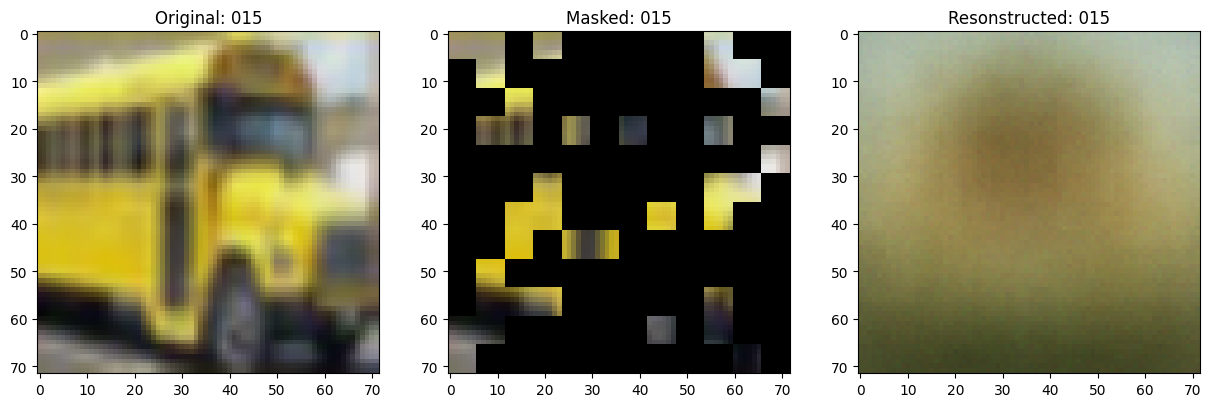


Epoch 16: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
196/196 ━━━━━━━━━━━━━━━━━━━━ 138s 703ms/step - mae: 0.1225 - loss: 0.4779 - val_loss: 0.4758 - val_mae: 0.1253 - learning_rate: 1.0000e-04
Epoch 17/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 699ms/step - mae: 0.1219 - loss: 0.4777 - val_loss: 0.4749 - val_mae: 0.1246 - learning_rate: 1.0000e-05
Epoch 18/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 699ms/step - mae: 0.1217 - loss: 0.4776 - val_loss: 0.4774 - val_mae: 0.1247 - learning_rate: 1.0000e-05
Epoch 19/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 699ms/step - mae: 0.1216 - loss: 0.4780 - val_loss: 0.4763 - val_mae: 0.1247 - learning_rate: 1.0000e-05
Epoch 20/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 697ms/step - mae: 0.1216 - loss: 0.4781 - val_loss: 0.4755 - val_mae: 0.1246 - learning_rate: 1.0000e-05
Epoch 21/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - mae: 0.1216 - loss: 0.4778
Idx chosen: 208


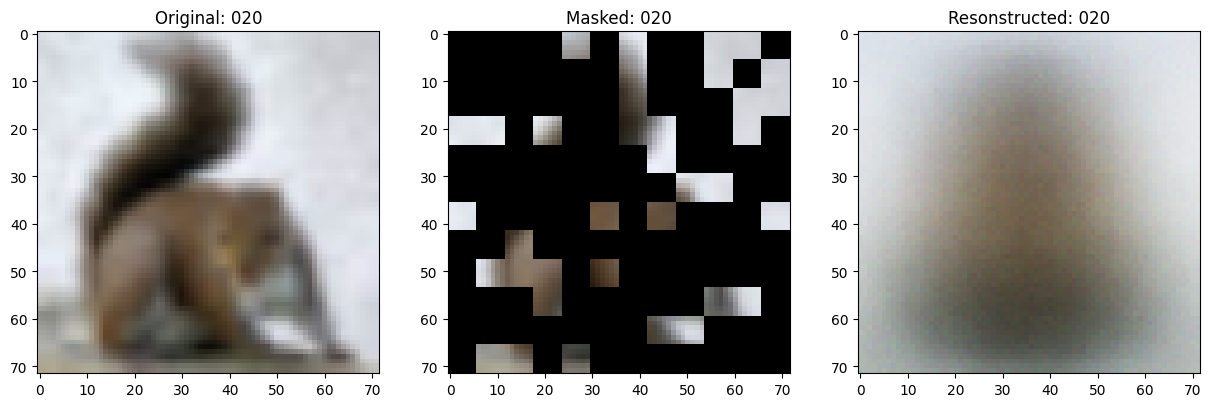


Epoch 21: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
196/196 ━━━━━━━━━━━━━━━━━━━━ 138s 703ms/step - mae: 0.1216 - loss: 0.4778 - val_loss: 0.4771 - val_mae: 0.1246 - learning_rate: 1.0000e-05
Epoch 22/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 699ms/step - mae: 0.1214 - loss: 0.4778 - val_loss: 0.4776 - val_mae: 0.1245 - learning_rate: 1.0000e-06
Epoch 23/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 698ms/step - mae: 0.1215 - loss: 0.4780 - val_loss: 0.4767 - val_mae: 0.1243 - learning_rate: 1.0000e-06
Epoch 24/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 698ms/step - mae: 0.1215 - loss: 0.4778 - val_loss: 0.4770 - val_mae: 0.1245 - learning_rate: 1.0000e-06
Epoch 25/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 698ms/step - mae: 0.1216 - loss: 0.4779 - val_loss: 0.4765 - val_mae: 0.1245 - learning_rate: 1.0000e-06
Epoch 26/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - mae: 0.1215 - loss: 0.4779
Idx chosen: 77


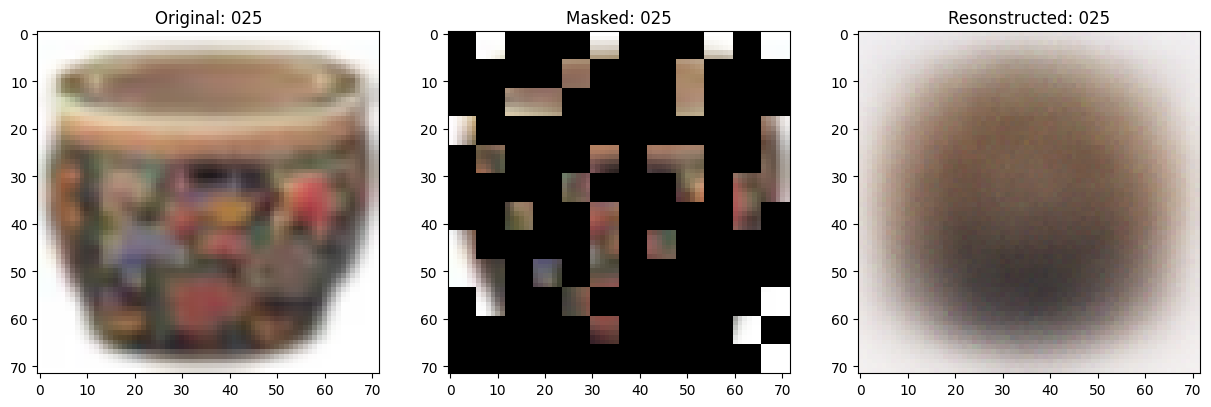


Epoch 26: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 702ms/step - mae: 0.1215 - loss: 0.4779 - val_loss: 0.4760 - val_mae: 0.1243 - learning_rate: 1.0000e-06
Epoch 27/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 699ms/step - mae: 0.1214 - loss: 0.4775 - val_loss: 0.4772 - val_mae: 0.1245 - learning_rate: 1.0000e-07
Epoch 28/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 698ms/step - mae: 0.1213 - loss: 0.4780 - val_loss: 0.4768 - val_mae: 0.1246 - learning_rate: 1.0000e-07
Epoch 29/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 699ms/step - mae: 0.1214 - loss: 0.4778 - val_loss: 0.4769 - val_mae: 0.1246 - learning_rate: 1.0000e-07
Epoch 30/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 137s 700ms/step - mae: 0.1214 - loss: 0.4778 - val_loss: 0.4779 - val_mae: 0.1244 - learning_rate: 1.0000e-07
Epoch 31/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - mae: 0.1215 - loss: 0.4782
Idx chosen: 89


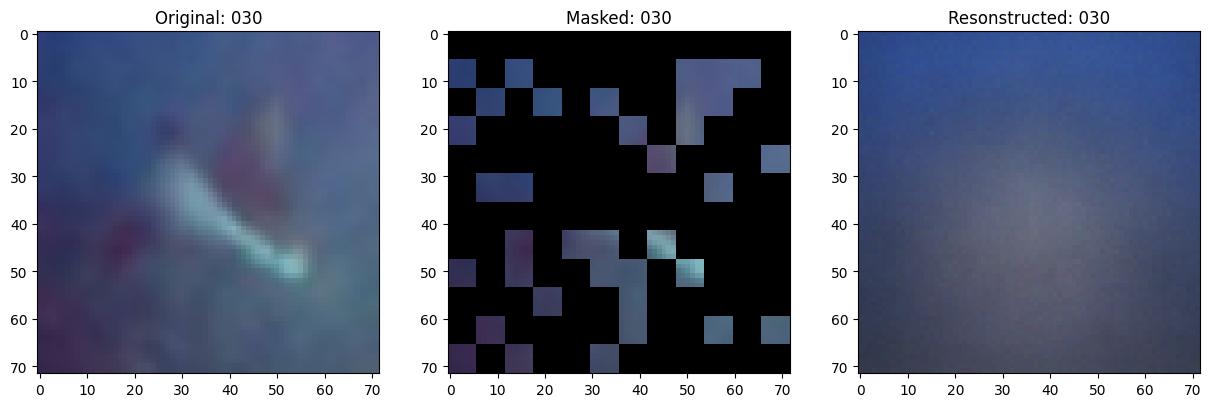


Epoch 31: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
196/196 ━━━━━━━━━━━━━━━━━━━━ 138s 703ms/step - mae: 0.1215 - loss: 0.4782 - val_loss: 0.4772 - val_mae: 0.1245 - learning_rate: 1.0000e-07
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 6.
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 329ms/step - mae: 0.1500 - loss: 0.4371
Loss: 0.44
MAE: 0.15


In [56]:
es = keras.callbacks.EarlyStopping(min_delta=1e-4, patience=25, verbose=1, restore_best_weights=True)
rlp = keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1)

history = mae_model.fit(
    train_ds, epochs=EPOCHS, validation_data=valid_ds, callbacks=[TrainMonitor(epoch_interval=5), es, rlp],
)

loss, mae = mae_model.evaluate(valid_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

**Downstream Classification Tasks**

In [60]:
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True

encoder = mae_model.encoder

downstream_model = keras.Sequential(
    [
        L.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        L.BatchNormalization(),
        L.GlobalAveragePooling1D(),
        L.Dense(10, activation="softmax"),
    ],
    name="downstream_model1",
)

In [61]:
def prepare_data(images, labels, is_train=True):
    if is_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)

(x_train, y_train), (x_valid, y_valid) = keras.datasets.cifar10.load_data()
train_ds = prepare_data(x_train, y_train)
valid_ds = prepare_data(x_valid, y_valid, is_train=False)

In [1]:
downstream_model.compile(
    optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

es = keras.callbacks.EarlyStopping(min_delta=1e-4, patience=75, verbose=1, restore_best_weights=True)
rlp = keras.callbacks.ReduceLROnPlateau(patience=10, verbose=1)

downstream_model.fit(train_ds, validation_data=valid_ds, epochs=30|, callbacks=[es, rlp])

loss, accuracy = downstream_model.evaluate(valid_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")

SyntaxError: invalid syntax (3161603045.py, line 8)